# Import libraries

In [117]:
# Install if not exists
# ! pip install -U numpy matplotlib seaborn scikit-learn ngboost

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Prepare artificial data

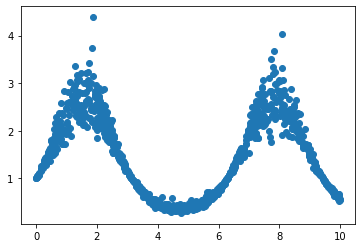

In [96]:
sample_size = 1000
x_lim = (0, 10)

X = np.random.uniform(*x_lim, sample_size)
Z = np.sin(X) + np.random.normal(loc=0, scale=0.15, size=sample_size)*np.sin(X)
y = np.exp(Z)
plt.scatter(X, y)

## Split into train/val set

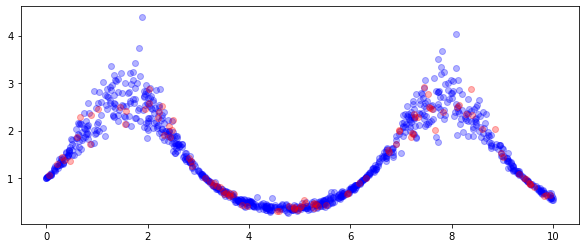

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, color='blue', alpha=0.3)
ax.scatter(X_val, y_val, color='red', alpha=0.3)
plt.show()

## Reshape as dataset

In [98]:
X_train = X_train.reshape(-1, 1)
X_val = X_val.reshape(-1, 1)

# Use NGBoost

In [99]:
from ngboost import NGBRegressor
from ngboost.distns import Normal, LogNormal, Exponential
from ngboost.scores import LogScore, MLE

In [100]:
NGBRegressor?

Init signature:
NGBRegressor(
    Dist=<class 'ngboost.distns.normal.Normal'>,
    Score=<class 'ngboost.scores.LogScore'>,
    Base=DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'),
    natural_gradient=True,
    n_estimators=500,
    learning_rate=0.01,
    minibatch_frac=1.0,
    verbose=True,
    verbose_eval=100,
    tol=0.0001,
    random_state=None,
)
Docstring:     
Constructor for NGBoost regression models.

NGBRegressor is a wrapper for the generic NGBoost class that facilitates regression. Use this class if you want to predict an outcome that could take an infinite number of (ordered) values.

Parameters:
    Dist          

## Training

In [101]:
ngb = NGBRegressor(
    Dist=LogNormal,
    Score=LogScore,
    n_estimators=500,
    learning_rate=0.01,
    verbose_eval=25
)

ngb.fit(X_train, y_train, X_val, y_val, 
        early_stopping_rounds=10)

[iter 0] loss=1.1905 val_loss=1.1635 scale=1.0000 norm=0.7469
[iter 25] loss=0.9798 val_loss=0.9601 scale=1.0000 norm=0.6170
[iter 50] loss=0.8331 val_loss=0.8175 scale=1.0000 norm=0.5558
[iter 75] loss=0.6924 val_loss=0.6747 scale=2.0000 norm=1.0352
[iter 100] loss=0.4655 val_loss=0.4492 scale=2.0000 norm=0.9706
[iter 125] loss=0.2387 val_loss=0.2248 scale=2.0000 norm=0.9457
[iter 150] loss=0.0186 val_loss=0.0065 scale=2.0000 norm=0.9301
[iter 175] loss=-0.1871 val_loss=-0.1952 scale=2.0000 norm=0.9132
[iter 200] loss=-0.3776 val_loss=-0.3749 scale=2.0000 norm=0.8926
[iter 225] loss=-0.5487 val_loss=-0.5286 scale=2.0000 norm=0.8701
[iter 250] loss=-0.6964 val_loss=-0.6505 scale=2.0000 norm=0.8535
[iter 275] loss=-0.8188 val_loss=-0.7303 scale=2.0000 norm=0.8433
[iter 300] loss=-0.9138 val_loss=-0.7732 scale=2.0000 norm=0.8467
[iter 325] loss=-0.9860 val_loss=-0.7826 scale=2.0000 norm=0.8634
== Early stopping achieved.
== Best iteration / VAL 318 (val_loss=-0.7841)


NGBRegressor(Base=DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'),
             Dist=<class 'ngboost.api.NGBRegressor.__init__.<locals>.DistWithUncensoredScore'>,
             Score=<class 'ngboost.scores.LogScore'>, learning_rate=0.01,
             minibatch_frac=1.0, n_estimators=500, natural_gradient=True,
             random_state=RandomState(MT19937) at 0x1132E0BA0, tol=0.0001,
             verbose=True, verbose_eval=25)

## Obtain Normal distribution parameters

In [102]:
X_grid = np.linspace(*x_lim, 500).reshape(-1, 1)
y_pred = ngb.predict(X_grid, max_iter=ngb.best_val_loss_itr)
y_pred_dist = ngb.pred_dist(X_grid, max_iter=ngb.best_val_loss_itr)

In [103]:
sigmas = y_pred_dist.params['s']
scales = y_pred_dist.params['scale']
mus = np.log(scales)

## Visualize trained conditional distribution

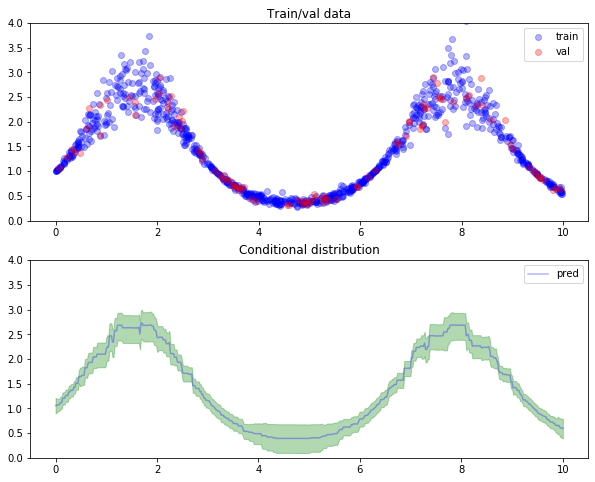

In [116]:
y_pred_plus = np.exp(mus) + 2*sigmas
y_pred_minus = np.exp(mus) - 2*sigmas

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.set_ylim(0, 4.0)
ax1.scatter(X_train, y_train, color='blue', alpha=0.3, label='train')
ax1.scatter(X_val, y_val, color='red', alpha=0.3, label='val')
ax1.set_title('Train/val data')
ax1.legend()

ax2= fig.add_subplot(212)
ax2.set_ylim(0, 4.0)
ax2.plot(X_grid, y_pred, color='blue', alpha=0.3, label='pred')
ax2.fill_between(X_grid.reshape(-1), y_pred_plus, y_pred_minus, alpha=0.3, color='green')
ax2.set_title('Conditional distribution')
ax2.legend()
plt.show()